# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse

# Combine files to create our DataFrame

In [3]:
df1 = pd.read_csv('audi.csv')
df2 = pd.read_csv('bmw.csv')
df3 = pd.read_csv('ford.csv')
df4 = pd.read_csv('merc.csv')
df5 = pd.read_csv('toyota.csv')

used_cars_data = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)

# Cleaning the Data

In [4]:
used_cars_data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [5]:
used_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59271 entries, 0 to 59270
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         59271 non-null  object 
 1   year          59271 non-null  int64  
 2   price         59271 non-null  int64  
 3   transmission  59271 non-null  object 
 4   mileage       59271 non-null  int64  
 5   fuelType      59271 non-null  object 
 6   tax           59271 non-null  int64  
 7   mpg           59271 non-null  float64
 8   engineSize    59271 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 4.1+ MB


In [6]:
#checking for missing values
total_missing = used_cars_data.isnull().sum().sort_values(ascending=False)
percent_missing = (used_cars_data.isnull().sum()/used_cars_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
print(missing_data)

              Total  Percent
model             0      0.0
year              0      0.0
price             0      0.0
transmission      0      0.0
mileage           0      0.0
fuelType          0      0.0
tax               0      0.0
mpg               0      0.0
engineSize        0      0.0


In [7]:
#checking for duplicated rows
total_duplicated = used_cars_data.duplicated().sum()
print(total_duplicated)

672


In [8]:
#dropping duplicated rows
used_cars_data = used_cars_data.drop_duplicates()

In [9]:
#checking for non numeric values in numeric columns
for column_name in ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']:
    print("Problematic values in column: {}".format(column_name))
    for value in used_cars_data[column_name]:
        try:
            float(value)
        except:
            print(value)

Problematic values in column: year
Problematic values in column: price
Problematic values in column: mileage
Problematic values in column: tax
Problematic values in column: mpg
Problematic values in column: engineSize


In [10]:
#checking for zeros that don't make sense
print(used_cars_data['engineSize'].value_counts()[0])
used_cars_data = used_cars_data[used_cars_data['engineSize'] != 0]

168


In [11]:
#checking for odd values in categorical columns and dropping if needed
used_cars_data.transmission.value_counts()

Manual       27323
Semi-Auto    16175
Automatic    14931
Other            2
Name: transmission, dtype: int64

In [12]:
used_cars_data = used_cars_data[used_cars_data['transmission'] != 'Other']

In [13]:
used_cars_data.fuelType.value_counts()

Petrol      28037
Diesel      27721
Hybrid       2520
Other         148
Electric        3
Name: fuelType, dtype: int64

In [14]:
used_cars_data = used_cars_data[used_cars_data['fuelType'] != 'Other']

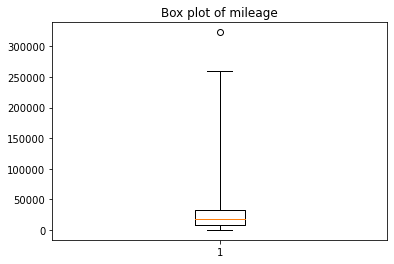

In [15]:
#checking for outliers and dropping if they seem to be a mistake, or a special case that wouldn't fit the model
#ex: car from the year 2060 = mistake
#ex: 1970 mint condition corvette stingray = special case that doesn't help the model
plt.boxplot(used_cars_data['mileage'], whis=10)
plt.title('Box plot of mileage')
plt.show()

In [16]:
used_cars_data = used_cars_data[used_cars_data['mileage'] < 300000]

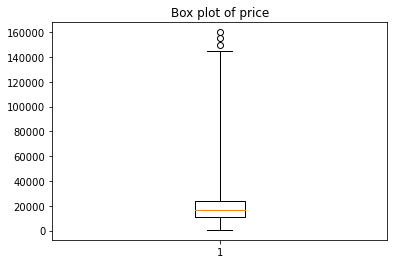

In [17]:
plt.boxplot(used_cars_data['price'], whis=10)
plt.title('Box plot of price')
plt.show()

In [18]:
used_cars_data = used_cars_data[used_cars_data['price'] < 140000]

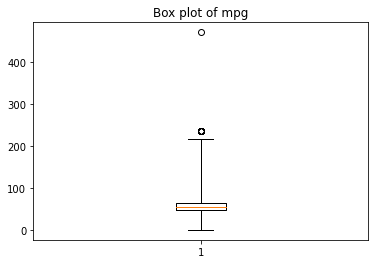

In [19]:
plt.boxplot(used_cars_data['mpg'], whis=10)
plt.title('Box plot of mpg')
plt.show()

In [20]:
used_cars_data = used_cars_data[used_cars_data['mpg'] > 5]
used_cars_data = used_cars_data[used_cars_data['mpg'] < 200]

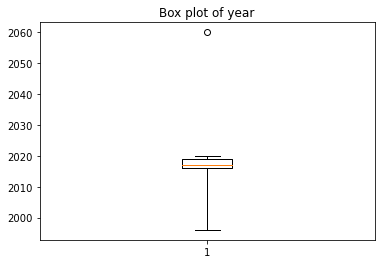

In [21]:
plt.boxplot(used_cars_data['year'], whis=10)
plt.title('Box plot of year')
plt.show()

In [22]:
used_cars_data = used_cars_data[used_cars_data['year'] < 2022]

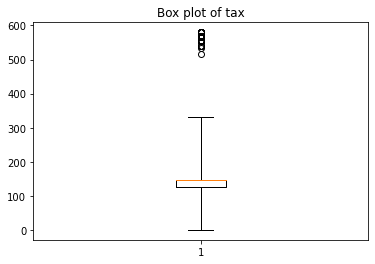

In [23]:
plt.boxplot(used_cars_data['tax'], whis=10)
plt.title('Box plot of tax')
plt.show()

In [24]:
used_cars_data = used_cars_data[used_cars_data['tax'] < 400]

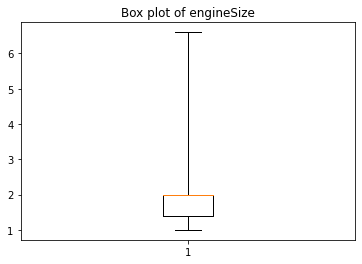

In [25]:
plt.boxplot(used_cars_data['engineSize'], whis=10)
plt.title('Box plot of engineSize')
plt.show()

In [26]:
used_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58075 entries, 0 to 59270
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         58075 non-null  object 
 1   year          58075 non-null  int64  
 2   price         58075 non-null  int64  
 3   transmission  58075 non-null  object 
 4   mileage       58075 non-null  int64  
 5   fuelType      58075 non-null  object 
 6   tax           58075 non-null  int64  
 7   mpg           58075 non-null  float64
 8   engineSize    58075 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 4.4+ MB


# EDA

Text(0.5, 1.0, 'engineSize')

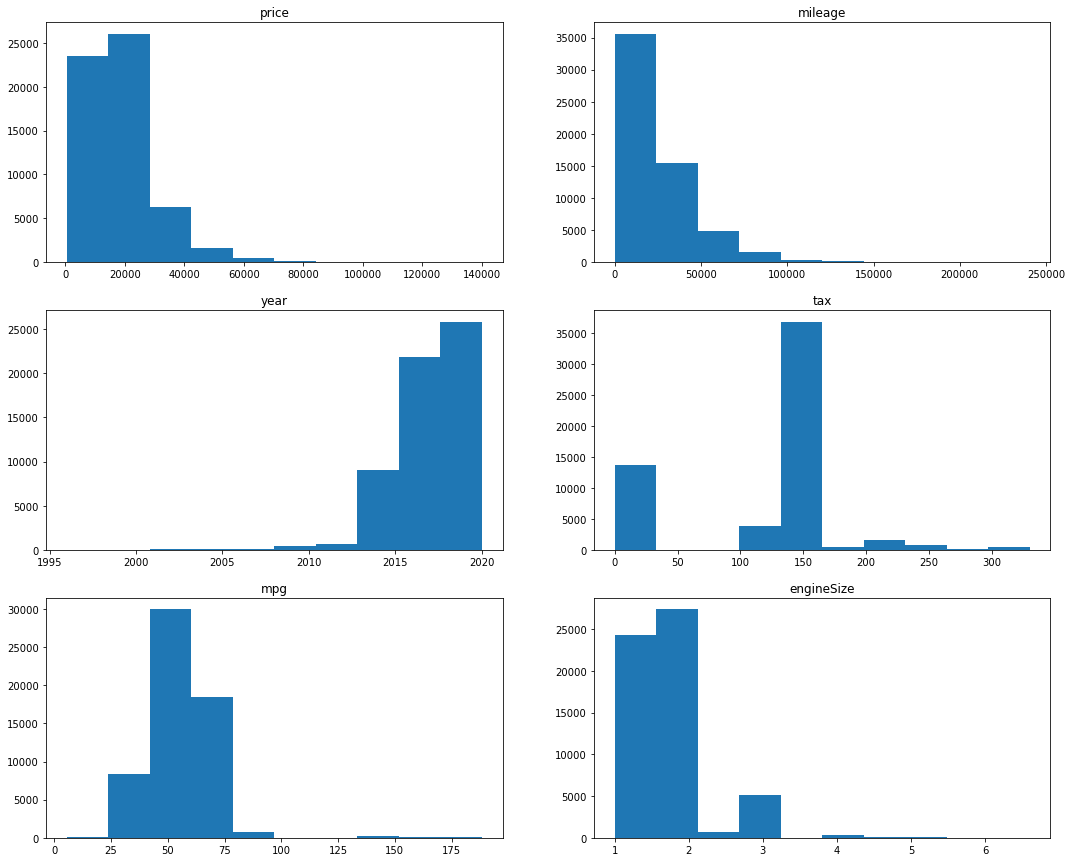

In [27]:
#visualizing the data
plt.figure(figsize=(18,15))

plt.subplot(3, 2, 1)
plt.hist(used_cars_data["price"])
plt.title("price")

plt.subplot(3, 2, 2)
plt.hist(used_cars_data["mileage"])
plt.title("mileage")

plt.subplot(3, 2, 3)
plt.hist(used_cars_data["year"])
plt.title("year")

plt.subplot(3, 2, 4)
plt.hist(used_cars_data["tax"])
plt.title("tax")

plt.subplot(3, 2, 5)
plt.hist(used_cars_data["mpg"])
plt.title("mpg")

plt.subplot(3, 2, 6)
plt.hist(used_cars_data["engineSize"])
plt.title("engineSize")


In [28]:
used_cars_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,58075.00000,58075.000000,58075.000000,58075.000000,58075.000000,58075.000000
mean,2017.02619,18787.117073,23698.877142,119.248730,56.024852,1.776334
std,2.15504,10937.942831,21539.094368,61.989538,13.663628,0.601689
min,1996.00000,495.000000,1.000000,0.000000,5.500000,1.000000
25%,2016.00000,11000.000000,7639.500000,125.000000,47.900000,1.400000
50%,2017.00000,16498.000000,17948.000000,145.000000,56.500000,2.000000
75%,2019.00000,23450.000000,33130.500000,145.000000,64.200000,2.000000
max,2020.00000,139995.000000,240494.000000,330.000000,188.300000,6.600000


In [29]:
#checking correlation with price for numeric columns
used_cars_data.corr()

,year,price,mileage,tax,mpg,engineSize
year,1.000000,0.520272,-0.748448,0.208873,-0.145623,-0.009701
price,0.520272,1.000000,-0.444944,0.331566,-0.439576,0.655458
mileage,-0.748448,-0.444944,1.000000,-0.223979,0.202043,0.078702
tax,0.208873,0.331566,-0.223979,1.000000,-0.542222,0.290127
mpg,-0.145623,-0.439576,0.202043,-0.542222,1.000000,-0.348588
engineSize,-0.009701,0.655458,0.078702,0.290127,-0.348588,1.000000


Notice that tax is the least correlated with price(our target). Let's drop the tax column. 

In [30]:
used_cars_data.drop(['tax'], axis=1)

,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,49.6,1.0
...,...,...,...,...,...,...,...,...
59266,IQ,2011,5500,Automatic,30000,Petrol,58.9,1.0
59267,Urban Cruiser,2011,4985,Manual,36154,Petrol,50.4,1.3
59268,Urban Cruiser,2012,4995,Manual,46000,Diesel,57.6,1.4
59269,Urban Cruiser,2011,3995,Manual,60700,Petrol,50.4,1.3


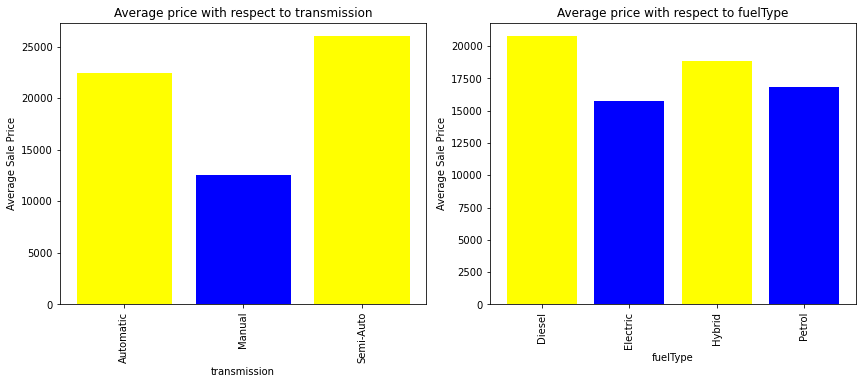

In [31]:
#checking correlation for non numeric columns

non_numeric_columns = used_cars_data.select_dtypes(['object']).columns

#We don't want to plot the models because there are too many different model types to be useful

non_numeric_columns = non_numeric_columns.drop(['model'])

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(10,5,index+1)
    plt.bar(used_cars_data.groupby(column)['price'].mean().index, used_cars_data.groupby(column)['price'].mean(), 
           color = ("yellow","blue"))
    plt.title("Average price with respect to {}".format(column))
    plt.ylabel("Average Sale Price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Transmission type shows a larger variance with respect to price so we will include it in the model for now

In [32]:
#one-hot encoding to be able to use the categorical features in the model
features_df = used_cars_data[['mileage', 'year', 'mpg', 'engineSize']]
transmission_df = pd.get_dummies(used_cars_data['transmission'], drop_first=True)
features_df = features_df.merge(transmission_df, left_index=True, right_index=True)

In [33]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58075 entries, 0 to 59270
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mileage     58075 non-null  int64  
 1   year        58075 non-null  int64  
 2   mpg         58075 non-null  float64
 3   engineSize  58075 non-null  float64
 4   Manual      58075 non-null  uint8  
 5   Semi-Auto   58075 non-null  uint8  
dtypes: float64(2), int64(2), uint8(2)
memory usage: 4.3 MB


# Running our Models

In [34]:
#splitting into train and test sets

X = features_df
Y = used_cars_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 46460
The number of observations in test set is 11615


In [35]:
#fit an OLS model using statsmodels

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 2.388e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:20:24   Log-Likelihood:            -4.6542e+05
No. Observations:               46460   AIC:                         9.309e+05
Df Residuals:                   46453   BIC:                         9.309e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.493e+06    3.6e+04    -97.128      0.0

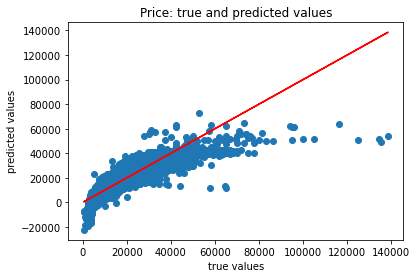

Mean absolute error of the prediction is: 3503.30914333732
Mean squared error of the prediction is: 27786416.193683036
Root mean squared error of the prediction is: 5271.282215332721
Mean absolute percentage error of the prediction is: 24.66090568403283


In [40]:
#making predictions on the test set

X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [37]:
#Now trying KNN to compare

rmse_val = [] #to store rmse values for different k
for K in range(15):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 9268.74481621906
RMSE value for k=  2 is: 8218.207785906437
RMSE value for k=  3 is: 7988.130199983765
RMSE value for k=  4 is: 7871.0708045996025
RMSE value for k=  5 is: 7825.238784225296
RMSE value for k=  6 is: 7796.6852570500005
RMSE value for k=  7 is: 7789.1161120049765
RMSE value for k=  8 is: 7789.657034161256
RMSE value for k=  9 is: 7791.9106806438
RMSE value for k=  10 is: 7812.275758774659
RMSE value for k=  11 is: 7828.050566501385
RMSE value for k=  12 is: 7826.69550686243
RMSE value for k=  13 is: 7829.943220943696
RMSE value for k=  14 is: 7856.544433781778
RMSE value for k=  15 is: 7861.306766130444


<AxesSubplot:>

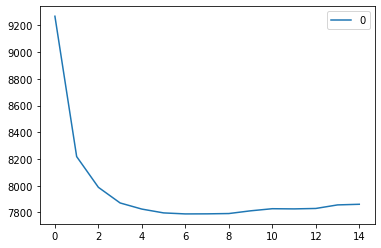

In [38]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [39]:
# Using K=7 (lowest RSME value) to check fit and find R-squared
knn_model = KNeighborsRegressor(n_neighbors=7).fit(X_train, y_train)

score_knn = knn_model.score(X_test, y_test)
print('R-squared is {}'.format(score_knn))

R-squared is 0.48326248002519445


# Summary

For this particular dataset, the OLS regression model outperforms the KNN regression model. The OLS model performs very vell on used car values under $50,000. 